**Задание:** *у нас есть данные АА-теста с '2022-11-25' по '2022-12-01'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.*

*1. Построить гистограмму распределения получившихся 10000 p-values.*

*2. Посчитать, какой процент p values оказался меньше либо равен 0.05*

*3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.*

*4. Пришлите ссылку на merge request c проведенным анализом.*

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np

In [2]:
from tqdm import tqdm
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [5]:
#загружаем данные за 25 ноября - 1 декабря по 2 и 3-ей экспериментальных групп
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-11-25' and '2022-12-01'
and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [6]:
'''отберем отдельно 2 и 3-ю группы'''
df_1 = df[df['exp_group'] == 3].ctr
df_2 = df[df['exp_group'] == 2].ctr

In [7]:
'''напишем функцию, которая 10к раз создаст выборки по 500 экз из 
каждой группы, проведет t-тест для каждой пары выборок и на выходе 
вернет массив из полученных p-value по тестам'''
def AA_test(df_1, df_2) -> list:
    result = []
    for _ in tqdm(range(10000)):
        group_1 = df_1.sample(500, replace = False)
        group_2 = df_2.sample(500, replace = False)
        _, p = stats.ttest_ind(group_1, group_2, equal_var=False)
        result.append(p)
    return result    

In [8]:
''' зададим зерно для воспроизводимости и активируем вышеприведенную 
функцию, используя в качестве аргументов ctr по 2 и 3ей группам'''
np.random.seed(3)
result = AA_test(df_1, df_2)

100%|██████████| 10000/10000 [00:15<00:00, 631.85it/s]


<AxesSubplot:>

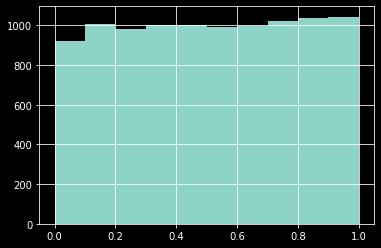

In [9]:
''' построим гистограмму, как просят по условию'''
t = pd.Series(result)
t.hist()

In [10]:
'''Определим какой процент p-value меньше 0.05'''
(t<0.05).mean()

0.0454

**Вывод: с учетом того, что распределение p-value близко к равномерному (как видно из гистограммы выше), 
а также с учетом того, что в нашей симуляции процент значений c p-value<0.05 равно около 5%,
следовательно, система сплитования работает корректно.**